# Haqathon: Traveling Salesman Problem using Variational Algorithms

Wenyang Qian    
March 21st: 9:00 - 20:00

The **Traveling Salesman Problem**, or **TSP** for short, is one of the most intensively studied problems in computational mathematics. 

People have devoted to the history, applications, and current research of this challenge of finding the shortest route visiting each member of a collection of locations and returning to your starting point.

For over a century, TSP has inspired hundreds of works and dozens of algorithms, of both exact and heuristic approaches. Today, the TSP has become so quintessential in modern computing that it is commonly considered the prototypical NP-Hard combinatorial optimization problem, possessing far-reaching impact on countless applications in science, industry and society. See website [here](https://www.math.uwaterloo.ca/tsp/) from University of Waterloo and others for more information about TSP.

Today, we aim to come up with solutions to solve the TSP using quantum variational algorithms. 



<img src="image/tsp.webp" width=400>

In [118]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.visualization import plot_histogram
from qiskit.primitives import Estimator, Sampler, StatevectorEstimator, StatevectorSampler
import qiskit_aer
import qiskit_algorithms
import qiskit

print('Qiskit version:', qiskit.version.get_version_info())

Qiskit version: 1.3.0


## 1. Problem Formulation of TSP

The TSP data that people typically use is from [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/index.html), stored in ".tsp" text files. 

For simplicity, we focus on **symmetric TSP** where going from A to B is the same as going from B to A. I have downloaded these files and added some other files under "data" directory.

One can use "TSPParser" class (credit: [tsartsaris](https://github.com/tsartsaris/TSPLIB-python-parser)) to convert the text file to Python data and also visualize it! You may look at the text files and play with the one you like. Here is a map in Berlin.

data/berlin52.tsp
52
['1', '565.0', '575.0']
['2', '25.0', '185.0']
['3', '345.0', '750.0']
['4', '945.0', '685.0']
['5', '845.0', '655.0']
['6', '880.0', '660.0']
['7', '25.0', '230.0']
['8', '525.0', '1000.0']
['9', '580.0', '1175.0']
['10', '650.0', '1130.0']
['11', '1605.0', '620.0']
['12', '1220.0', '580.0']
['13', '1465.0', '200.0']
['14', '1530.0', '5.0']
['15', '845.0', '680.0']
['16', '725.0', '370.0']
['17', '145.0', '665.0']
['18', '415.0', '635.0']
['19', '510.0', '875.0']
['20', '560.0', '365.0']
['21', '300.0', '465.0']
['22', '520.0', '585.0']
['23', '480.0', '415.0']
['24', '835.0', '625.0']
['25', '975.0', '580.0']
['26', '1215.0', '245.0']
['27', '1320.0', '315.0']
['28', '1250.0', '400.0']
['29', '660.0', '180.0']
['30', '410.0', '250.0']
['31', '420.0', '555.0']
['32', '575.0', '665.0']
['33', '1150.0', '1160.0']
['34', '700.0', '580.0']
['35', '685.0', '595.0']
['36', '685.0', '610.0']
['37', '770.0', '610.0']
['38', '795.0', '645.0']
['39', '720.0', '635.0']
['40'

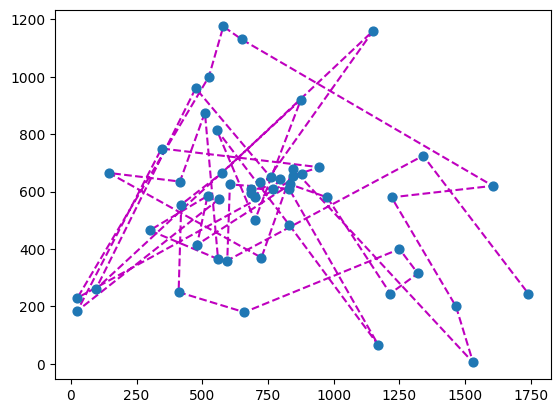

In [119]:
from HaqatonTSP.parser import TSPParser
TSPParser(filename="data/berlin52.tsp", plot_tsp=True)

As you can see, TSP problem is essentially best routing problem with graphs! The cities are the nodes and the roads between them become the edges of the graph. The traveling distances of each road is the corresponding edge weight. To understand TSP, we need to under Graph theory.

In graph theory, it is convenient to introduce the concept of **adjacency matrix** to describe the connectivity inside the graph. An adjacency matrix $M$ is a square matrix used to represent a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph. 

Specifically, we also store edge weights directly int he elements of an adjacency matrix. Here, we use $M_{ij} =0$ to indicate there is no edge connecting city $i$ and $j$, and $M_{ij} = d$ to indicate there is a road of distance $d$ connecting city $i$ and $j$.

Here are two examples:

<img src="image/tsp_case1.png" width=350>
The adjacency matrix for the above graph should be: 
$ \quad\quad M = \begin{pmatrix}
    0 & 2 & 1 & 0 \\
    2 & 0 & 0 & 3 \\
    1 & 0 & 0 & 2 \\
    0 & 3 & 2 & 0 
    \end{pmatrix} 
$

<img src="image/tsp_case2.png" width=350>
The adjacency matrix for the above graph should be: 
$ \quad\quad M = \begin{pmatrix}
    0 & 2 & 1 & 3 \\
    2 & 0 & 3 & 3 \\
    1 & 3 & 0 & 2 \\
    3 & 3 & 2 & 0 
    \end{pmatrix} 
$

Note, we start our city index from 0, for Python is 0-indexed. 

To make it easier for you, I wrote for you the following **TSPGraph** class to build and visualize the TSP from any adjacency matrix. The above examples can be built easily. When rendering the city indices might switch places for optimal presentation.

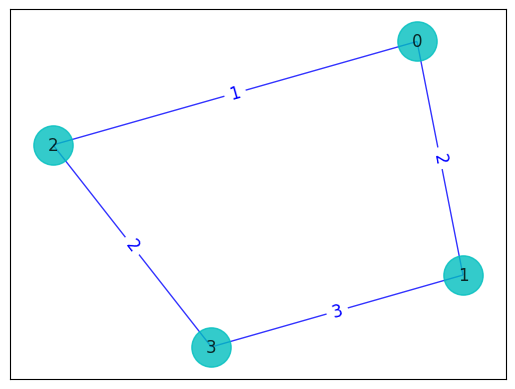

In [120]:
from HaqatonTSP.tsp import TSPGraph

# use tha adjaceny matrix above
M = \
[[0,2,1,0], 
 [2,0,0,3], 
 [1,0,0,2], 
 [0,3,2,0]]

tsp1 = TSPGraph(num_nodes=4, adj_matrix=M)
tsp1.draw()

In [121]:
tsp1.get_sols(keep_unique=False)

(8,
 [(0, 1, 3, 2),
  (0, 2, 3, 1),
  (1, 0, 2, 3),
  (1, 3, 2, 0),
  (2, 0, 1, 3),
  (2, 3, 1, 0),
  (3, 1, 0, 2),
  (3, 2, 0, 1)])

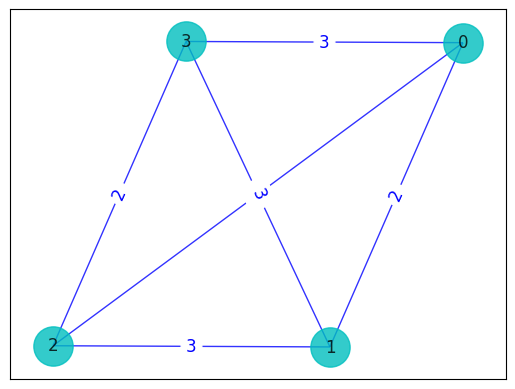

In [122]:
# use tha adjaceny matrix above

M = \
[[0,2,1,3], 
 [2,0,3,3], 
 [1,0,3,2], 
 [3,3,2,0]]

tsp2 = TSPGraph(num_nodes=4, adj_matrix=M)
tsp2.draw()

One can also use the class to get a random TSP graph, by **not specifying** the adjacency matrix. Additioanlly, one can specficy the connectivity of the edges (edge_freq) with 1 being fully connected and 0 being fully disjointed, and max_weight for the maximum edge weight allocated. One can also play with seed values to generate a variety of graphs.

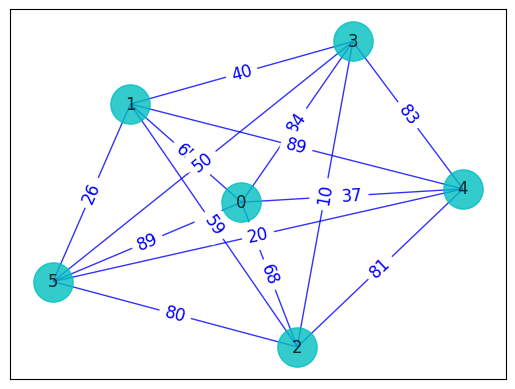

In [123]:
tsp3 = TSPGraph(num_nodes=6, seed=0, edge_freq=1.0, max_weight=100)
tsp3.draw()

You can use **get_adj_matrix()** function to print out the adjacency matrix.

In [124]:
tsp3.get_adj_matrix()

array([[ 0., 65., 68., 84., 37., 89.],
       [65.,  0., 59., 40., 89., 26.],
       [68., 59.,  0., 10., 81., 80.],
       [84., 40., 10.,  0., 83., 50.],
       [37., 89., 81., 83.,  0., 20.],
       [89., 26., 80., 50., 20.,  0.]])

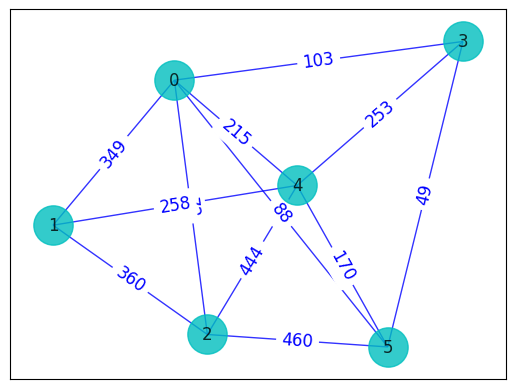

In [125]:
tsp4 = TSPGraph(num_nodes=6, seed=42, edge_freq=0.7, max_weight=500)
tsp4.draw()

In [126]:
tsp4.get_adj_matrix()

array([[  0., 349.,  72., 103., 215.,  88.],
       [349.,   0., 360.,   0., 258.,   0.],
       [ 72., 360.,   0.,   0., 444., 460.],
       [103.,   0.,   0.,   0., 253.,  49.],
       [215., 258., 444., 253.,   0., 170.],
       [ 88.,   0., 460.,  49., 170.,   0.]])

## 2. Exact Classical Solution

Here, you can solve the TSP problem for both the optimal distance and route using bruteforce algorithm provided by the class.

Note the algorithm scales worse than exponential, since $\mathcal{O(n!)} > \mathcal{O}(2^n)$, for a $n$-node TSP graph. So, it will fail terribly (taking forever to run) when $n$ is large.

In [127]:
tsp1.get_sols()

(8, [(0, 2, 3, 1), (0, 1, 3, 2)])

The **get_sols()** function returns the best distance and a list of possible route path. For example, the first TSP graph has a best distance of 8, with possible routes (0,2,3,1) representing 0 -> 2 -> 3 -> 1 -> 0 and (0,1,3,2) representing 0 -> 1 -> 3 -> 2 -> 0. Importantly, for TSP, there could be multiple best route path correspond to the same one best distance. Note, it is assumed that you will return to the starting city.

One can also use the **draw_with_bf_sol()** to draw the best path on graph.

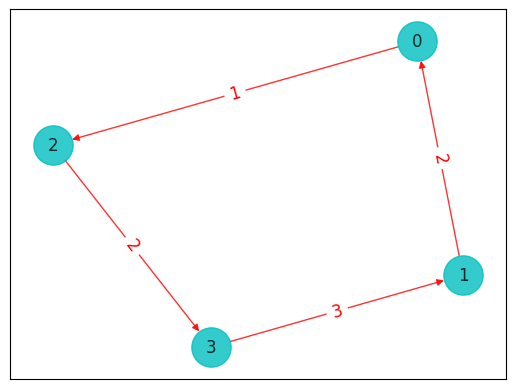

In [128]:
tsp1.draw_with_bf_sol()

Now, you can experiment with the other graphs.

In [129]:
tsp2.get_sols()

(8, [(0, 2, 3, 1), (0, 1, 3, 2)])

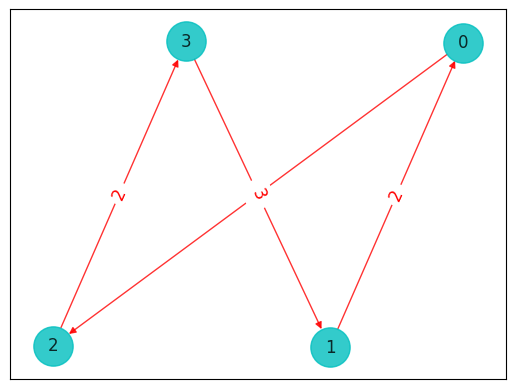

In [130]:
tsp2.draw_with_bf_sol()

In [131]:
tsp3.get_sols()

(201, [(0, 4, 5, 1, 3, 2), (0, 2, 3, 1, 5, 4)])

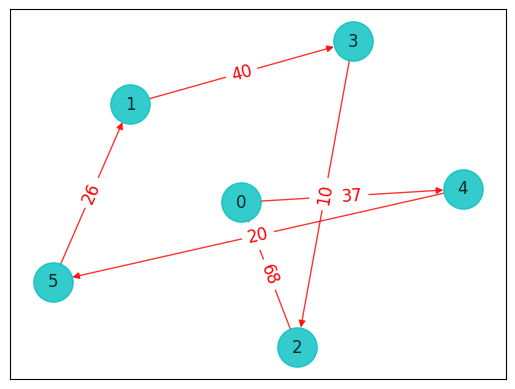

In [132]:
tsp3.draw_with_bf_sol()

In [133]:
tsp4.get_sols()

(1012, [(0, 2, 1, 4, 5, 3), (0, 3, 5, 4, 1, 2)])

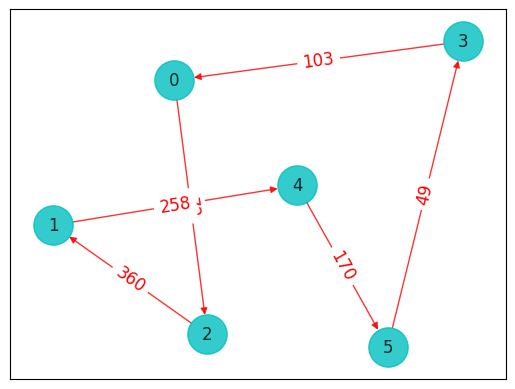

In [134]:
tsp4.draw_with_bf_sol()

Note it is possible to have a TSP **without a best distance**, if an edge between two nodes are not availble. For example, you can set freqence of the edge to be very low. Because in our setup, each edge is only allowed to be used once.

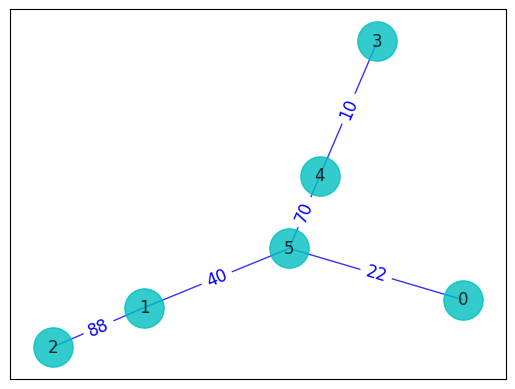

In [135]:
tsp5 = TSPGraph(num_nodes=6, seed=0, edge_freq=0.5, max_weight=100)
tsp5.draw()

In [136]:
tsp5.get_sols()

(inf, None)

## 3. Approximate Quantum Solution using Variational Algorithms

Here, you will solve the TSP problem using quantum variational algorithms, such as QAOA or VQE.

Some useful resources:

* Qiskit tutorial, Max-cut and TSP, [GitHub](https://github.com/qiskit-community/qiskit-optimization/blob/main/docs/tutorials/06_examples_max_cut_and_tsp.ipynb)

* Ising formulations of many NP problems, [1302.5843](https://arxiv.org/abs/1302.5843)   

* Comparative Study of Variations in Quantum Approximate Optimization Algorithms for the Traveling Salesman Problem, [2307.07243](https://arxiv.org/abs/2307.07243)

...

You can see that like Max-cut problem you learned in class, TSP can also be formulated using Ising Model, which is basically some weighted sum of Pauli-$Z$ and Pauli-$ZZ$ operators. 

### a. TSP Problem Formulation as Optimization Probelm
First step is forumlate TSP as an **optimization problem**. Optimization problem allows us to go much beyond exact solution by bruteforce. The optimization problem comes with **three important parts**.

1. What are the quantum state? How are solutions represented?
   
2. What is the cost operator for representing the TSP graph that we try to minimize?

3. What are the constraints for the TSP problem? Why are the contraints necessary?

#### a.1. Quantum state to represent solution

In this graph formulation of the TSP, any valid cycle, be it minimum or not, can be represented by a visiting order or a permutation of integers, such as $\{0, 1, ..., n-1\}$, where the integers are the city indices starting at 0 for a total of $n$ cities. 

Alternatively, the visiting order on a TSP graph can be conveniently described by a sequence of **binary decision variables**, $x_{i,t}$, indicating whether the city-$i$ is visited at time $t$. If $x_{i,t}=1$ then the city-$i$ is visited at $t$, otherwise the city is not visited by the traveling salesman. 

Naively, to fully describe the solution to a $n$-city TSP, a total of $n^2$ binary variables is needed in this representation. 

Alternatively, this ``one-hot" representation of binary decision variables can be written collectively in either **matrix** or **flattened array format** for numerical implementation. For instance, a valid Hamiltonian cycle of permutation $x=(0, 1, 2, 3)$, is translated into binary decision variables $x$ as
$$
\begin{equation}
\begin{aligned}
    x =(0, 1, 2, 3) 
    \equiv
    \begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
    \end{pmatrix} 
    \equiv 1000010000100001 ,
\end{aligned}
\end{equation}
$$
where the matrix row index represents each city index, and the column index represents each time instance. 

This is then very suitable for our quantum state. Take some time to think this through. If needed, you can also look at the references.

#### a.2. TSP cost operator

With binary decision variables $x$, a true solution to an $n$-city TSP can be found by finding an $x$ that minimizes the following cost function,
$$
\begin{align}
    C_\mathrm{dist}(x) = \sum_{0\leq i,j<n} \omega_{ij} \sum_{t=0}^{n-1} x_{i,t} x_{j,t+1},
\end{align}
$$
where $\omega_{ij}$ is the distance (or edge weight in the undirected graph) between city-$i$ and city-$j$.

Note: in symmetric TSP, $\omega_{ij} = \omega_{ji}$ and $\omega_{ii}=0$.

Now it is your time to implement this using what you learned from the Max-cut problem. 

You function should take in an adjaceny matrix (a $2^n$ by $2^n$ matrix) for a TSP graph and return the cost operator for this TSP in terms of Pauli strings. Importantly as a sanity check, you should end up with only Pauli-Z and Pauli-ZZ operators.

In [137]:
X = SparsePauliOp('X')
Y = SparsePauliOp('Y')
Z = SparsePauliOp('Z')
I = SparsePauliOp('I')

def x_op(i, n):
    ''' Return an operator (I-Z)/2 at specified qubit index i, with n qubits in total '''
    candidates = [I]*n
    candidates[i] = (I - Z)/2
    res = candidates[0]
    for i in range(1, n):
        res = res^candidates[i]
    return res

def I_op(n):
    ''' Return an identity operator over n qubits'''
    return SparsePauliOp(["I"*n], [1])

   
def build_TSP_cost_operator(num_nodes, TSP_adj_matrix):
    '''
    Return the TSP cost operator that we try to minimize.
    '''
    G = TSP_adj_matrix
    total = 0
    n_city = n_time = len(G)
    # for i, j in G.edges():  # using edges() will cause a bug, Qian 03/14/2022
    # loop idxs incorrect: fixed on 08/20/2022
    
    n_qubit = n_city*n_time
    for i in range(n_city): # 0,1,..,n-1
        for j in range(n_city):
            if i == j or G[i][j] == 0: continue
            w = G[i][j]
            for t in range(n_time):
                idx1 = n_time*i+t
                idx2 = n_time*j+((t+1) % n_time)
                assert idx1 != idx2
                total += w* x_op(idx1, n=n_qubit) @ x_op(idx2, n=n_qubit)   
            
    return total.simplify()

In [138]:
num_nodes = 3

M = \
[[0,2,1], 
 [2,0,3], 
 [1,3,0]]

tsp = TSPGraph(num_nodes=num_nodes, adj_matrix=M)
# tsp.draw()

build_TSP_cost_operator(3, M)

SparsePauliOp(['IIIIIIIII', 'IIIIZIIII', 'ZIIIIIIII', 'ZIIIZIIII', 'IIIIIZIII', 'IZIIIIIII', 'IZIIIZIII', 'IIIZIIIII', 'IIZIIIIII', 'IIZZIIIII', 'IIIIIIIZI', 'ZIIIIIIZI', 'IIIIIIIIZ', 'IZIIIIIIZ', 'IIIIIIZII', 'IIZIIIZII', 'IZIZIIIII', 'IIZIZIIII', 'ZIIIIZIII', 'IIIZIIIZI', 'IIIIZIIIZ', 'IIIIIZZII', 'IZIIIIZII', 'IIZIIIIZI', 'ZIIIIIIIZ', 'IIIIZIZII', 'IIIIIZIZI', 'IIIZIIIIZ'],
              coeffs=[ 9.  +0.j, -2.5 +0.j, -1.5 +0.j,  0.5 +0.j, -2.5 +0.j, -1.5 +0.j,
  0.5 +0.j, -2.5 +0.j, -1.5 +0.j,  0.5 +0.j, -2.  +0.j,  0.25+0.j,
 -2.  +0.j,  0.25+0.j, -2.  +0.j,  0.25+0.j,  0.5 +0.j,  0.5 +0.j,
  0.5 +0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,  0.25+0.j,  0.25+0.j,
  0.25+0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j])

#### a.3. TSP constraint equations

You should quickly see that not all decision variables are valid. Some of those are not a possible route and some of those violate causality. 

For example, each row of the matrix representation of the decision variables must have 1 appearing once. Otherwise, the TSP person is at the same city all the time. 

Likewise, each column of the matrix representation of the decision variables must have 1 appearing once. Otherwise, the TSP person is simultaneous at all the cities!!

What do you think is the constraints here?

Yes, the matrix must faithly represent a permutation matrix. Much in the same spirit as **Soduku**, the decision variable must has exactly 1 in any row and any column!

For this, we categorize the **decision variable $x$ into three categories**:

$$
\begin{align}
    x &= \begin{cases}
        \textbf{true}, & \text{$x$ is a permutation and gives the shortest path,}\\
        \textbf{false}, & \text{$x$ is a permutation but does not give the shortest path,}\\
        \textbf{invalid}, & \text{$x$ is not a permutation,}
    \end{cases}
\end{align}
$$

Write a few $x$ and determine if it is valid (true + false) or invalid.

Then, how do we materialize this fact in our setup? 

Since the cost function itself does not forbid invalid solutions in general, additional constraint conditions must be satisfied for a valid Hamiltonian cycle, such as
$$
\begin{align}
    \sum_{i=0}^{n-1} x_{i,t} &= 1\quad \text{for $t=0,1,\cdots,n-1$}  \\
    \sum_{t=0}^{n-1} x_{i,t} &= 1\quad \text{for $i=0,1,\cdots,n-1$} 
\end{align}
$$
where the former equation forbids multiple cities visited by the traveler at the same time, and latter equation forbids revisiting the same city. 

To formulate the TSP as a minimum-optimization problem, these constraint conditions are conveniently incorporated as the penalty terms, such that the combined cost function, $C(x)$ becomes,
$$
\begin{align}
    C(x) =&\, C_\mathrm{dist}(x) + \lambda C_\mathrm{penalty}(x) \\ =&\sum_{0\leq i,j<n} \omega_{ij} \sum_{t=0}^{n-1} x_{i,t} x_{j,t+1}
    + \lambda \bigg\{\sum_{t=0}^{n-1}\Big(1-\sum_{i=0}^{n-1} x_{i,t}\Big)^2 
    + \sum_{i=0}^{n-1}\Big(1-\sum_{t=0}^{n-1} x_{i,t}\Big)^2\bigg\},
\end{align}
$$
where $\lambda$ is the weight factor of the penalty term, serving as the Lagrange multiplier. $\lambda$ should be positive and sufficiently large. 

It is easy to see bit string $x$ gives the minimum of $C(x)$ **if and only if** $x$ is a true solution to the given TSP. 

Now our problem is equivalent to finding an $x^*$ that **minimizes** $C(x)$, i.e. $x^* = {\arg \min}\, C(x)$.

In [139]:
def constraint_square(idxs, n_city):
    n_qubit = n_city**2
    s = I_op(n=n_qubit)
    for idx in idxs:
        s -= x_op(idx, n=n_qubit)
    return (s @ s).simplify()

def build_TSP_penalty_operator(num_nodes, lambda_factor):
    '''
    Return the TSP penalty operator that we try to enforce the constraint upto some weight lambda_factor.
    '''
    
    n_city = n_time = num_nodes 
    n_qubit = n_city*n_time
    total = 0
    # time constraint on each city:
    for i in range(n_city):
        idxs = [n_time*i+j for j in range(n_time)]
        total += constraint_square(idxs, n_city)
    # city constraint on each time step:
    for j in range(n_time):
        idxs = [n_time*i+j for i in range(n_city)]
        total += constraint_square(idxs, n_city)    
    return (total*lambda_factor).simplify()

In [140]:
def build_full_TSP_operator(num_nodes, TSP_adj_matrix, lambda_factor):
    '''
    Return the full TSP operator that we try to minimize.
    '''
    op1 = build_TSP_cost_operator(num_nodes, TSP_adj_matrix)
    op2 = build_TSP_penalty_operator(num_nodes, lambda_factor)

    
    
    return (op1 + op2).simplify()

In [141]:
num_nodes = 3

M = \
[[0,2,1], 
 [2,0,3], 
 [1,3,0]]

tsp = TSPGraph(num_nodes=num_nodes, adj_matrix=M)
# tsp.draw()

tsp_cost_operator = build_full_TSP_operator(3, M, 100)
tsp_H_operator  = build_TSP_cost_operator(3, M)
tsp_operator, tsp_H_operator

(SparsePauliOp(['IIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIII', 'IIIIIIZIIIIIIIII', 'IZIIIIIIIIIIIIII', 'IZIIIIZIIIIIIIII', 'IIIIIIIZIIIIIIII', 'IIZIIIIIIIIIIIII', 'IIZIIIIZIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIIZZIIIIIIIIIII', 'IIIIIIIIIZIIIIII', 'ZIIIIIIIIZIIIIII', 'IIIIIIIIIIZIIIII', 'IZIIIIIIIIZIIIII', 'IIIIIIIIIIIZIIII', 'IIZIIIIIIIIZIIII', 'IIIIIIIIZIIIIIII', 'IIIZIIIIZIIIIIII', 'IIIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZIII', 'IIIZIIIIIIIIZIII', 'IZIIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIIZIIIIIIIII', 'ZIIIIIIZIIIIIIII', 'IIIIZIIIIZIIIIII', 'IIIIIZIIIIZIIIII', 'IIIIIIZIIIIZIIII', 'IIIIIIIZZIIIIIII', 'IIIIZIIIIIIIIZII', 'IIIIIZIIIIIIIIZI', 'IIIIIIZIIIIIIIIZ', 'IIIIIIIZIIIIZIII', 'IZIIIIIIZIIIIIII', 'IIZIIIIIIZIIIIII', 'IIIZIIIIIIZIIIII', 'ZIIIIIIIIIIZIIII', 'IIIIIZIIZIIIIIII', 'IIIIIIZIIZIIIIII', 'IIIIIIIZIIZIIIII', 'IIIIZIIIIIIZIIII', 'III

Make sure the operator you got is still an Ising operator.

Then you can use exact diagonalization to verify the best distance using numpy.



In [142]:
# as an example using numpy to find eigenvalues
mat = tsp_cost_operator.to_matrix()

# print out the first 10 eigenvalues
sorted(np.linalg.eigvals(mat))[:10]

[np.complex128(6+0j),
 np.complex128(6+0j),
 np.complex128(6+0j),
 np.complex128(6+0j),
 np.complex128(6+0j),
 np.complex128(6+0j),
 np.complex128(201+0j),
 np.complex128(201+0j),
 np.complex128(201+0j),
 np.complex128(201+0j)]

In [143]:
# as an example using numpy to find eigenvalues
mat = tsp_H_operator.to_matrix()

# print out the first 10 eigenvalues
sorted(np.linalg.eigvals(mat))[:10]

[np.complex128(0j),
 np.complex128(0j),
 np.complex128(0j),
 np.complex128(0j),
 np.complex128(0j),
 np.complex128(0j),
 np.complex128(0j),
 np.complex128(0j),
 np.complex128(0j),
 np.complex128(0j)]

### b. Variational Ansatz for TSP

Congratulations!

Getting here is significant!!! Now, the floor is yours. Try VQE or QAOA setup that you learned to see if you can extract the optimal distance and route. **Try start with VQE**, as it is a simple heuristic approach.



In [144]:
# try go to Max-cut notebook if this is not very clear.

# def run_VQE_on_TSP(num_qubits, tsp_operator, VQE_ansatz, optimizer, shots):
from qiskit_algorithms.optimizers import COBYLA

def run_VQE_on_TSP(tsp_operator, ansatz, shots, maxiter=300, random_seed=0, verbose=True):
    '''
    Run the quantum simulation and return the tsp cost and the optimal parameter for your VQE_ansatz
    '''
    
    # Helper function
    exp_val_list = []
    def callback(params):
        '''
        Callback to record expectation history and more!
           It is always optimizer dependent, so very tricky in general, for other optimizers, 
           you will need modify the argument to callback(num_eval, param, f_eval, step, acc) instead
        '''
        exp_val = get_expectation(ansatz, params, observable, shots)
        exp_val_list.append(exp_val)
        if verbose == True: print(f"step {len(exp_val_list):>4}:  <H> = {exp_val:>6.3f}")
    
    initial_parameters = [0.1]*ansatz.num_parameters
    observable = tsp_operator
    
    def minimize_func(params):
        ##### ==================================
        # Write your solution in here.     
        value_to_maximize = get_expectation(ansatz, params, observable, shots)
        ##### ==================================
        return value_to_maximize

    np.random.seed(random_seed)
    initial_params = 0.1* np.random.random(ansatz.num_parameters)
    opt = COBYLA(maxiter=maxiter, callback=callback)
    
    res = opt.minimize(minimize_func, initial_params)
    
    return res, exp_val_list
    
    
    
def get_expectation(ansatz, params, observable, shots):
    assert ansatz.num_qubits == observable.num_qubits, f"ansatz qubits = {ansatz.num_qubits}, observable qubits = {observable.num_qubits}"
    assert len(params) == ansatz.num_parameters
    ##### ==================================
    # Write your solution in here.  
    circuit = ansatz.assign_parameters(params)
    expectation = estimate_with_shots(circuit, observable, shots)
    ##### ==================================
    return expectation

from qiskit.circuit.library import TwoLocal
def get_ansatz(n, layers):
    ##### ==================================
    # Write your solution in here.  
    ansatz = TwoLocal(n, "ry", "cz", reps=layers, entanglement="linear")
    ##### ==================================
    return ansatz

# you can use the estimator_with_shots function from our class.
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

def estimate_with_shots(circuit, observable, shots):
    ''' Using Estimator class from earlier Qiskit versions (will be deprecated soon)
        Still useful because one can implement shot simulation
        Ref: https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Estimator
    '''
    _circuit = circuit.copy()
    _circuit.remove_final_measurements()
    shot_estimator = Estimator(options={"shots": shots})
    expectation = shot_estimator.run(_circuit, observable).result().values[0]
    return expectation

def estimate_with_shots_v2(circuit, observable):
    ''' Using StatevectorEstimator class from Qiskit 1.3 
        Ref: https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorEstimator
    '''
    _circuit = circuit.copy()
    _circuit.remove_final_measurements()
    shot_estimator = StatevectorEstimator(shots=shots)
    pub = (circuit, [[observable]])
    expectation = shot_estimator.run([pub]).result()[0].data.evs[0]
    return expectation

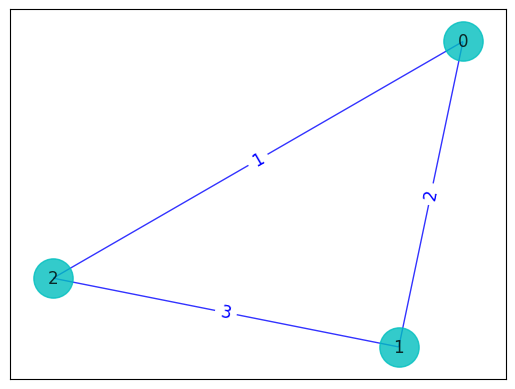

In [145]:
num_nodes = 3

M = \
[[0,2,1], 
 [2,0,3], 
 [1,3,0]]

tsp = TSPGraph(num_nodes=num_nodes, adj_matrix=M)
tsp.draw()

In [146]:
tsp.get_sols()

(6, [(0, 1, 2), (0, 2, 1)])

In [147]:
tsp_operator = build_full_TSP_operator(3, M, 10)

# building ansatz and observable
ansatz = get_ansatz(len(M)**2, 8)
shots = 8192

opt_res, exp_val_list = run_VQE_on_TSP(tsp_operator, ansatz, shots, maxiter=500, random_seed=0, verbose=True)

step    1:  <H> = 45.464
step    2:  <H> = 42.001
step    3:  <H> = 41.508
step    4:  <H> = 38.843
step    5:  <H> = 37.729
step    6:  <H> = 39.162
step    7:  <H> = 37.124
step    8:  <H> = 37.464
step    9:  <H> = 36.538
step   10:  <H> = 36.960
step   11:  <H> = 34.571
step   12:  <H> = 35.258
step   13:  <H> = 33.981
step   14:  <H> = 34.593
step   15:  <H> = 35.840
step   16:  <H> = 34.002
step   17:  <H> = 37.663
step   18:  <H> = 36.698
step   19:  <H> = 41.211
step   20:  <H> = 34.371
step   21:  <H> = 35.755
step   22:  <H> = 36.328
step   23:  <H> = 34.761
step   24:  <H> = 36.559
step   25:  <H> = 34.001
step   26:  <H> = 36.998
step   27:  <H> = 36.738
step   28:  <H> = 39.770
step   29:  <H> = 33.975
step   30:  <H> = 36.795
step   31:  <H> = 36.483
step   32:  <H> = 35.260
step   33:  <H> = 36.253
step   34:  <H> = 33.751
step   35:  <H> = 38.501
step   36:  <H> = 36.090
step   37:  <H> = 32.290
step   38:  <H> = 37.028
step   39:  <H> = 33.859
step   40:  <H> = 34.282


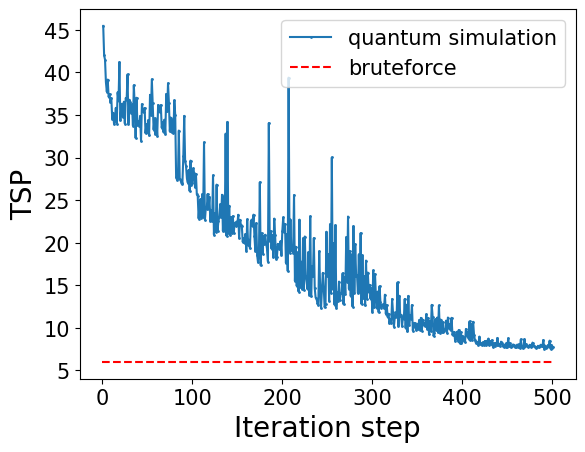

In [148]:
def plot_vqe_exp_val_list(exp_val_list, bf_dist):
    N = len(exp_val_list)
    xs = np.arange(1, N+1)
    plt.plot(xs, exp_val_list, 'o-', ms=1, label='quantum simulation')
    plt.ylabel(r'TSP', fontsize=20)
    plt.xlabel('Iteration step', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.hlines(bf_dist, 0, N, ls='dashed', color='red', label='bruteforce')
    plt.legend(fontsize=15)
    plt.show()
    
# visualize result   
plot_vqe_exp_val_list(exp_val_list, 6)



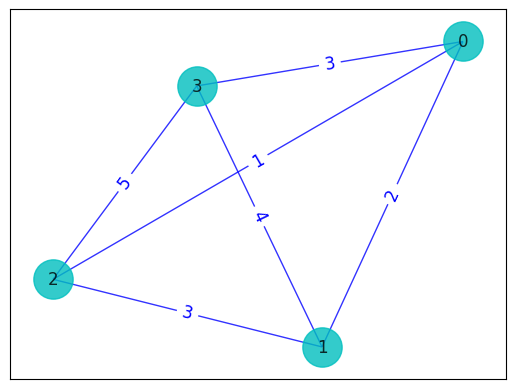

step    1:  <H> = 70.347
step    2:  <H> = 65.768
step    3:  <H> = 63.582
step    4:  <H> = 63.415
step    5:  <H> = 60.225
step    6:  <H> = 58.997
step    7:  <H> = 60.107
step    8:  <H> = 60.037
step    9:  <H> = 57.918
step   10:  <H> = 58.749
step   11:  <H> = 57.038
step   12:  <H> = 57.379
step   13:  <H> = 57.859
step   14:  <H> = 55.998
step   15:  <H> = 56.145
step   16:  <H> = 55.827
step   17:  <H> = 57.085
step   18:  <H> = 55.968
step   19:  <H> = 55.659
step   20:  <H> = 56.586
step   21:  <H> = 54.199
step   22:  <H> = 56.426
step   23:  <H> = 60.891
step   24:  <H> = 57.061
step   25:  <H> = 57.872
step   26:  <H> = 57.413
step   27:  <H> = 58.123
step   28:  <H> = 54.804
step   29:  <H> = 58.589
step   30:  <H> = 51.460
step   31:  <H> = 54.014
step   32:  <H> = 53.560
step   33:  <H> = 62.514
step   34:  <H> = 58.035
step   35:  <H> = 54.829
step   36:  <H> = 54.197
step   37:  <H> = 52.910
step   38:  <H> = 55.015
step   39:  <H> = 59.395
step   40:  <H> = 54.293


In [162]:
num_nodes = 4

M = \
[[0,2,1,3], 
 [2,0,3,4], 
 [1,3,0,5],
 [1,4,5,0]]

tsp = TSPGraph(num_nodes=num_nodes, adj_matrix=M)
tsp.draw()

tsp_operator = build_full_TSP_operator(4, M, 10)

# building ansatz and observable
ansatz = get_ansatz(len(M)**2, 4)
shots = 8192

opt_res, exp_val_list = run_VQE_on_TSP(tsp_operator, ansatz, shots, maxiter=300, random_seed=0, verbose=True)

In [163]:
tsp.get_sols()[0]

11

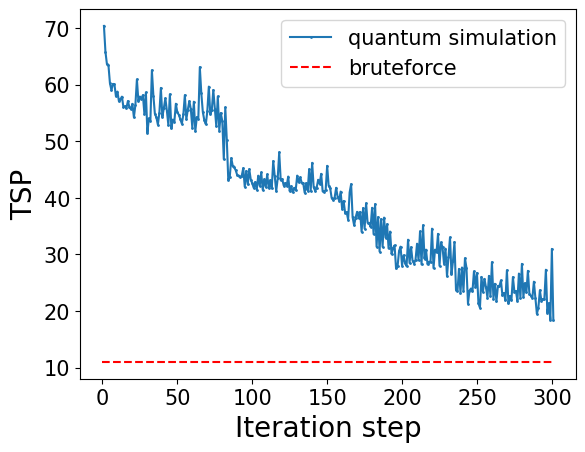

In [164]:
# visualize result   
plot_vqe_exp_val_list(exp_val_list, 11)

To test it, you can use $n=3$ nodes TSP graph to begin with.

You know the cost has to be 6 and one possible route is (1,0,2). See if that is what you get. 

To obtain the route, remember to use sampling techqniue on the optimized ansatz to find state with maximal probability.

In [165]:
def extract_TSP_route(ansatz, opt_res, shots):
    '''
    Sample the ansatz with optimization result and return best route and its probability.
    '''
    counts = sample_probability_dist(ansatz, opt_res, shots)
    best_prob = 0
    best_route = None
    for k, v in counts.items():
        if v > best_prob:
            best_route = k
            best_prob = v
            
    return best_route, best_prob

# you can use sample_probability_dist function from our class.
def sample_probability_dist(ansatz, optimization_result, shots):
    num_qubits = ansatz.num_qubits
    ##### ==================================
    # Write your solution in here. 
    optimal_param = optimization_result.x
    qc = ansatz.assign_parameters(optimal_param)
    qc.measure_all()
    dist = sample_with_shots(qc, shots, num_qubits)
    ##### ==================================
    return dist
    
# you can use sample_with_shots function from our class.
def sample_with_shots(circuit, shots, num_qubits, export_prob=True):
    ''' Using StatevectorSampler class from Qiskit 1.3 
        Ref: https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler
    '''
    shot_sampler = StatevectorSampler(default_shots=shots)
    pub = (circuit)
    job = shot_sampler.run([pub], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    probs = {k: v/shots for k, v in counts.items()}
    return probs if export_prob else counts
    


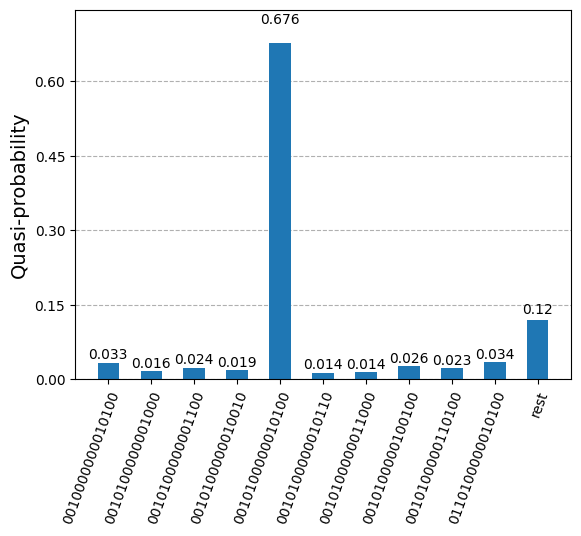

In [166]:
# for visualization

from qiskit.visualization import plot_histogram

counts = sample_probability_dist(ansatz, opt_res, shots)
plot_histogram(counts, number_to_keep=10)

In [167]:
best_route, best_prob = extract_TSP_route(ansatz, opt_res, shots)
best_route, best_prob

('0010100000010100', 0.6824951171875)

In [155]:
"2->0->3->1"

'2->0->3->1'

(11, [(0, 2, 1, 3), (0, 3, 1, 2)])


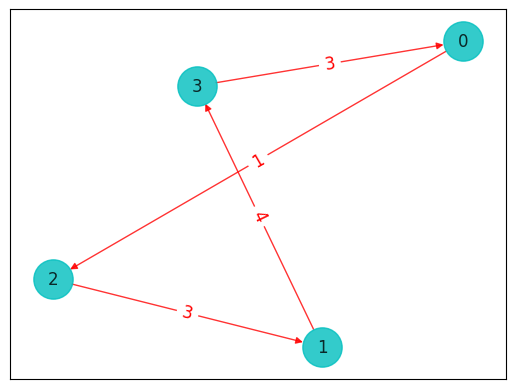

In [168]:
num_nodes = 4

M = \
[[0,2,1,3], 
 [2,0,3,4], 
 [1,3,0,5],
 [1,4,5,0]]

tsp = TSPGraph(num_nodes=num_nodes, adj_matrix=M)
print(tsp.get_sols())

tsp.draw_with_bf_sol()

### c. Optimize your setup to obtain Best Distance and Route

Now we will think of ways to improve our simulation, on more and more cities (successfully going up to 4-5 is already very good).

You can try with more shots, different optimizers, different initializations. If you used VQE, you should also try with QAOA. There are many things to improve this. Probably also good idea to read the paper.

At the end of the day, you are expected to come up with a **TSP solver**, that takes into any good TSP graph (adjacency matrix) and extract the best distance from quantum simulatoin! 

Have fun!!!

In [157]:
def TSP_solver(num_nodes, tsp_adj_matrix, lambda_factor):
    '''
    Run quantum simulation to obtain the best distance of any tsp graph (tsp_adj_matrix)
    Return: best_dist, best_route, best_prob
    '''
    M = tsp_adj_matrix
    tsp_op = build_full_TSP_operator(num_nodes, M, lambda_factor)
    ansatz = get_ansatz(len(M)**2, 8)
    shots = 1024
    opt_res, exp_val_list = run_VQE_on_TSP(tsp_op, ansatz, shots, maxiter=300, random_seed=0, verbose=False)
    best_route, best_prob = extract_TSP_route(ansatz, opt_res, shots)
    best_dist = min(exp_val_list)
    
    return best_dist, best_route, best_prob

(217, [(0, 1, 2), (0, 2, 1)])
[[ 0. 65. 68.]
 [65.  0. 84.]
 [68. 84.  0.]]


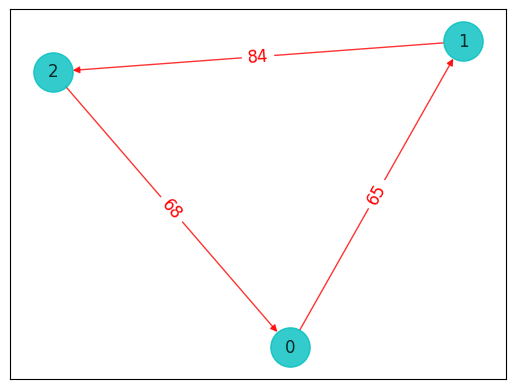

In [158]:
num_nodes = 3
max_weight = 100
edge_freq = 1.0

tsp = TSPGraph(num_nodes=num_nodes, edge_freq=edge_freq, max_weight=max_weight)
print(tsp.get_sols())

tsp_adj_matrix = tsp.get_adj_matrix()
print(tsp_adj_matrix)

tsp.draw_with_bf_sol()


In [159]:
from time import time

n_trials = 5
for _ in range(n_trials):
    t0 = time()
    print(TSP_solver(num_nodes, tsp_adj_matrix, lambda_factor=max_weight), f", time cost = {time()-t0:.2f}s")

(np.float64(281.0953098267148), '010000001', 0.7529296875) , time cost = 5.83s
(np.float64(294.16183523113864), '000001100', 0.494140625) , time cost = 5.84s
(np.float64(218.96179434558073), '010100001', 0.974609375) , time cost = 5.81s
(np.float64(271.61603877568734), '010001000', 0.72265625) , time cost = 5.99s
(np.float64(245.83779078100736), '010100001', 0.767578125) , time cost = 5.85s


## 4. Evaluation matrix

Here, you will try to improve your quantum solver for TSP problem. The performance of your solver will be evaluated based on the following crtierions

| Crtierion    | Description |
| :-------- | :------- |
| Number of Cities (n)  | number of TSP cities    |
| Simulation Time (t) | time to perform quantum simulation     |
| Approximation Ratio (AR)    | simulated optimal distance divided by the exact optimal distance    |


The score $\mathrm{S}$ for each $n$ is
$$\mathrm{S}_n = \frac{100}{\mathrm{AR}\log(t)},$$
and the total score of your Haqaton is
$$\mathrm{S} = \sum_{n} n^2 \mathrm{S}_n. $$

Since it is an approximation optimization, you have several trials for your simulation. The team with the highest score $\mathrm{S}$ will be winner for this project.


In [160]:
def score_n(sim_best_dist, bf_dist, sim_time, n):
    AR = (sim_best_dist/bf_dist)
    return n*n*100/AR/np.log2(sim_time)

In [169]:
# enter your time here.
n = 3
sim_best_dist = 218.96179434558073
bf_dist = 217
sim_time = 6.29
print("Score =", score_n(sim_best_dist, bf_dist, sim_time, n))


Score = 336.19157462505024
